# Predicting Company Bankruptcy using Liability Financial Metrics

## Introduction

The occurrence of bankruptcies that are linked to business failures are becoming a common concern for many companies and their stakeholders. They can occur through the natural course of progression (such as smartphone cameras replacing the non-professional dedicated camera market), or be exacerbated through exogenous shocks (such as the dot-com bubble of 2001, or the 2007 financial crisis).  

In this analysis, we will determine if we can predict the looming bankruptcy of a company based on a variety of fundamental financial metrics, specifically related to debt and liabilities. Narrowing further, we will be looking at metrics which may indicate an imminent bankruptcy as opposed to a drawn-out downfall.

We will use the Taiwanese Bankruptcy Prediction dataset from the Taiwan Economic Journal (TEJ), spanning from 1999-2009. Since its 1990 inception, the TEJ has focused on delivering essential financial market data [1]. Within this 1999-2000 period, the TEJ recorded 220 observations of bankruptcy within the total 6,819 observations they collected data on. Company bankruptcy was defined based on the business rules of the Taiwan Stock Exchange [2].

The dataset includes 95 columns of financial metrics, and a 96th column for a bankruptcy flag (yes/no).
We will use the bankruptcy flag as our classification variable.

[1] https://www.tejwin.com/en/about/

[2] Lyon,Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R.
#TO CHANGE TO REFERENCE SECTION

# Methods & Results

The process will start start off by reading necessary libraries:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)

options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

To read the data, we will need to:
1) Download the zip file from its source [2] above
2) Specify where to save the zip file
3) Unzip the file to our desired location

In [13]:
# Set an initial seed so analysis does not change between instances of reloading the file
set.seed(7834) 

#get file, which is stored as a .zip
url <- "https://archive.ics.uci.edu/static/public/572/taiwanese+bankruptcy+prediction.zip"
data_directory <- "data/"

dir.create(file.path(dirname(data_directory), "data")) #create the directory to save the file

zip_file_name <- "data.zip"
download.file(url, paste(data_directory, zip_file_name, sep=""), mode = "wb") #download file
#unzip the zipfile
unzip(paste(data_directory, zip_file_name, sep=""),exdir=data_directory) #unzip the data

Warning message in dir.create(file.path(dirname(data_directory), "data")):
“'./data' already exists”


Commentary on wrangling the data
- discussion regarding wrangling
- was any data missing?
- was it clean at the outset?
- Need a clear narrative explaining the steps taken to ensure data quality and integrity

The below will need to have more categories removed.

The data set is quite clean, for instance:
- The prediction column, bankrupt, contained either a 0 or 1, indicating if the company is bankrupt (1) or not (0).
- No column contained invalid data (ie., factors in a double column)
- No column contained missing data (ie., no blank or NA)

In the process of tidying,, we made the following adjustments to:
 1) Clean the headers of our data as numerous of them have spaces and/or invalid characters (such as "?" or "/")
 2) Change our classification column, "bankrupt", to a factor, and rename the 1 and 0 by their respective human definitions (1 = Bankrupt, 0 = Not Bankrupt).  This is what we are going to be predicting.
 3) Select the columns necessary to our analysis.  As we are looking to determine the bankruptcy of a company based on a subset of debt and liablity metrics, we will initially filter the data for columns containing the word "debt", and columns containing any form of the word "liability."
 4) Remove preliminary columns which fall within the selection but do not have relevant data for us, namely: interest_bearing_debt_interest_rate and liability_assets_flag
 5) Mutated the debt_ratio_percent column via a multiplication of 100 to provide a more human-understandable value for the category, which is a percentage

In [14]:
taiwan_data <- read_csv("data/data.csv") |>
               clean_names(replace = c('/' = " over ", '%' = "percent")) #the headers have numerous spaces and/or invalid characters.  But we we want to preserve % as "percent", and / as "over".

taiwan_preliminary <- taiwan_data |>
                mutate(bankrupt = fct_recode(factor(bankrupt), "Bankrupt" = '1', "Not Bankrupt" = '0'), debt_ratio_percent = debt_ratio_percent * 100) |> #change numerical values to factors/classifications.
                select(bankrupt, contains("debt"), contains("liabilit")) |>  #select 1) classification column (bankrupt), 2) columns containing "Debt", and 3) columns containing any form of liability
                select(!c(interest_bearing_debt_interest_rate, liability_assets_flag)) #remove two additional columns - interest rate, and liability asset flag.

taiwan_preliminary

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,total_debt_over_total_net_worth,debt_ratio_percent,contingent_liabilities_over_net_worth,quick_assets_over_current_liability,cash_over_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_over_current_liability,current_liabilities_over_liability,current_liabilities_over_equity,long_term_liability_to_current_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity,equity_to_liability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bankrupt,0.02126592,20.75763,0.006478502,0.001996771,1.47336e-04,0.14730845,0.3340152,0.001035990,0.6762692,0.3390770,0.025592368,0.6762692,0.3390770,0.1265495,0.4586091,0.11825048,0.2902019,0.01646874
Bankrupt,0.01250239,17.11763,0.005835039,0.004136030,1.38391e-03,0.05696283,0.3411060,0.005209682,0.3085886,0.3297401,0.023946819,0.3085886,0.3297401,0.1209161,0.4590011,0.04777528,0.2838460,0.02079431
Bankrupt,0.02124769,20.75158,0.006561982,0.006302481,5.34000e+09,0.09816206,0.3367315,0.013878786,0.4460275,0.3347769,0.003715116,0.4460275,0.3347769,0.1179223,0.4592540,0.02534649,0.2901885,0.01647411
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Not Bankrupt,0.0013915866,3.893944,0.005365848,0.035531293,0.088212480,0.02441366,0.3588474,0.007809807,0.5539642,0.3269206,0.0e+00,0.5539642,0.3269206,0.1109332,0.4524647,0.007542458,0.2757887,0.09764874
Not Bankrupt,0.0038163762,8.697887,0.007067734,0.007753306,0.007133218,0.08319943,0.3802508,0.013333639,0.8932409,0.3292936,3.2e+09,0.8932409,0.3292936,0.1109574,0.4713133,0.022916427,0.2775472,0.04400945
Not Bankrupt,0.0004614304,1.414880,0.006368212,0.051480515,0.066673545,0.01851735,0.2395847,0.000000000,1.0000000,0.3266903,0.0e+00,1.0000000,0.3266903,0.1109332,0.4832848,0.005579107,0.2751141,0.23390224


The initial tiding and wrangling narrowed down the financial metrics to those which include debt and/or liabilities to 19 columns. Within that 19, we have the following:

- **Bankruptcy Flag (Y/N)**
- Total debt over total net worth
- **Debt ratio (as a percentage)**
- Contingent liabilities over net worth
- **Quick assets over current liability**
- Cash over current liability
- Current liability to assets
- Operating funds to liability
- Inventory over current liability
- Current liabilities over liability
- Current liabilities over equity
- Long term liability to current assets
- **Current liability to liability**
- Current liability to equity
- Equity to long-term liability
- Cash flow to liability
- Current Liability to current assets
- Liability to equity, and
- Equity to liability

That said, we noticed something strange when data wrangling. Some of the categories had identical values but with similar (yet still unique) names. For instance: current_liabilities_over_liability shared identical data with current_liability_to_liability.  We ultimately determined the categories were oriented in such a way so that other data scientists, who may be looking specifically for "current liabilities" vs "current liability" can use those columns.  
To preserve the quality and integrity of our analysis, we will not be using the duplicated categories.

As we are interested in factors which may predict the imminent bankruptcy of a company, we further narrowed the 19 columns down to just 4:
- **Bankruptcy Flag:** our predictor variable.
- **Debt ratio (as a percentage):** represents the amount of leverage used by a company in terms of total debt to total assets. (https://www.investopedia.com/terms/d/debtratio.asp)
- **Quick assets over current liability:** also known as the "quick ratio", represents the extent to which a business can pay its short-term obligations with its most liquid assets, not including inventory. (https://www.netsuite.com/portal/resource/articles/financial-management/quick-ratio.shtml)
- **Current liability to liability:** represents the proportion of all liabilities which are due within the next 12 months to the total amount of liabilities (https://www.bdc.ca/en/articles-tools/entrepreneur-toolkit/templates-business-guides/glossary/current-liabilities)

In [15]:
taiwan_tidy <- taiwan_preliminary |>
                select(bankrupt, debt_ratio_percent, quick_assets_over_current_liability, current_liabilities_over_liability)
taiwan_tidy

bankrupt,debt_ratio_percent,quick_assets_over_current_liability,current_liabilities_over_liability
<fct>,<dbl>,<dbl>,<dbl>
Bankrupt,20.75763,0.001996771,0.6762692
Bankrupt,17.11763,0.004136030,0.3085886
Bankrupt,20.75158,0.006302481,0.4460275
⋮,⋮,⋮,⋮
Not Bankrupt,3.893944,0.035531293,0.5539642
Not Bankrupt,8.697887,0.007753306,0.8932409
Not Bankrupt,1.414880,0.051480515,1.0000000


In spot-checking our data, we noticed three observations did not make sense as they had quick ratios exceeding over 1,000,000,000.  Generally speaking, a quick ratio should remain at or around 1.  It may also fall below 1 in numerous circumstances,  such as if the company were to have strong terms with their lenders or if they were using debt financing (https://www.theforage.com/blog/skills/quick-ratio).

We filtered out the observations where quick_assets_over_current_liability exceeded 1.0 as they had the capability to greatly skew the data in inappropriate ways.  This leaves us with 6,816 observations.

In [16]:
head(arrange(taiwan_tidy, -quick_assets_over_current_liability), n = 6)

taiwan_tidy <- taiwan_tidy |>
                filter(quick_assets_over_current_liability <= 1)
taiwan_tidy

bankrupt,debt_ratio_percent,quick_assets_over_current_liability,current_liabilities_over_liability
<fct>,<dbl>,<dbl>,<dbl>
Not Bankrupt,19.9534420,8.820000e+09,0.998851283
Not Bankrupt,14.0550836,8.140000e+09,0.996929132
Not Bankrupt,31.2755087,7.540000e+09,0.999816524
Not Bankrupt,0.1511624,1.000000e+00,0.063817399
Not Bankrupt,0.0000000,3.251893e-01,0.425415889
Not Bankrupt,5.7985912,2.750005e-01,0.007776519


bankrupt,debt_ratio_percent,quick_assets_over_current_liability,current_liabilities_over_liability
<fct>,<dbl>,<dbl>,<dbl>
Bankrupt,20.75763,0.001996771,0.6762692
Bankrupt,17.11763,0.004136030,0.3085886
Bankrupt,20.75158,0.006302481,0.4460275
⋮,⋮,⋮,⋮
Not Bankrupt,3.893944,0.035531293,0.5539642
Not Bankrupt,8.697887,0.007753306,0.8932409
Not Bankrupt,1.414880,0.051480515,1.0000000


Following the data wrangling and tidying, we separated our data into respective training and testing groups.  We used a proportion of 75% for separating the data, using our prediction column, bankrupt, as the strata.

Initially, we were cautious about the ratio of bankrupt observations. Of the 6,816 observations, only 220 are labelled bankrupt, which represents approximately 3.23% of the observations. However as we will see below, this still leaves us with 165 bankrupt observations in the training set and 55 bankrupt observations in the testing set, which the team determined still provided a sufficient set for both training and testing..

Commentary on summarizing the data set which is relevant for exploratory data analysis related to the planned analsys



In [17]:
#code here
# Following a bit of data tidying, we will separate our data into respective training and testing groups.
# As there are only 220 instances of bankruptcy in the dataset of 6,816 observations (and it is also the column we are trying to predict),
# we will select bankrupt as our strata.

taiwan_initial_split <- initial_split(taiwan_tidy, prop = 0.75, strata = bankrupt)
taiwan_initial_training <- training(taiwan_initial_split)
taiwan_initial_testing <- testing(taiwan_initial_split)



A summary of the split is found below.

In [7]:
# Set an initial seed so analysis does not change between instances of reloading the file
set.seed(7834) 
taiwan_training_count <- taiwan_initial_training |>
                                          group_by(bankrupt) |>
                                          summarize(observations_training = n())
taiwan_testing_count <- taiwan_initial_testing |>
                                          group_by(bankrupt) |>
                                          summarize(observations_testing = n())
taiwan_training_count
taiwan_testing_count 

bankrupt,observations_training
<fct>,<int>
Not Bankrupt,4947
Bankrupt,165


bankrupt,observations_testing
<fct>,<int>
Not Bankrupt,1649
Bankrupt,55


We created three new dataframes to aid in the visualization of our data.

In [20]:
#This creates a new dataframe for the purposes of organizing the columns to better fit our intended visualizations.
taiwan_viz <- taiwan_initial_training |>
              pivot_longer(cols = -bankrupt, names_to = 'category', values_to ='value') 

#This creates a new dataframe to group the data by bankrupt and a respective mean value for each column.
taiwan_training_all_mean_summary <- taiwan_initial_training |>
                                          group_by(bankrupt) |>
                                          summarize_all(mean)

#This creates a new dataframe for the purposes of highlighting the mean value of the taiwan_viz dataframe and to add labels to the graph.
taiwan_viz_mean <- taiwan_training_all_mean_summary |>
              pivot_longer(cols = -bankrupt, names_to = 'category', values_to ='value_mean') |>
              mutate(x = c(6, 0.03, 0.45, 32, 0.003, 0.45), y = c(3, 1, 4.5, 3.5, 1.3, 4))


In creating a prudent visualization, we opted for a density plot to visualize the distribution of our numeric variables.  It allows us to contrast the ranges of differences between bankrupt and not-bankrupt companies.  Given our variables resolve to ratios, we determined scaling the x-axis logarithmically provided the most clear depiction of ranges.  Finally, we highlighted the average for each variable based on bankruptcy status.

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”


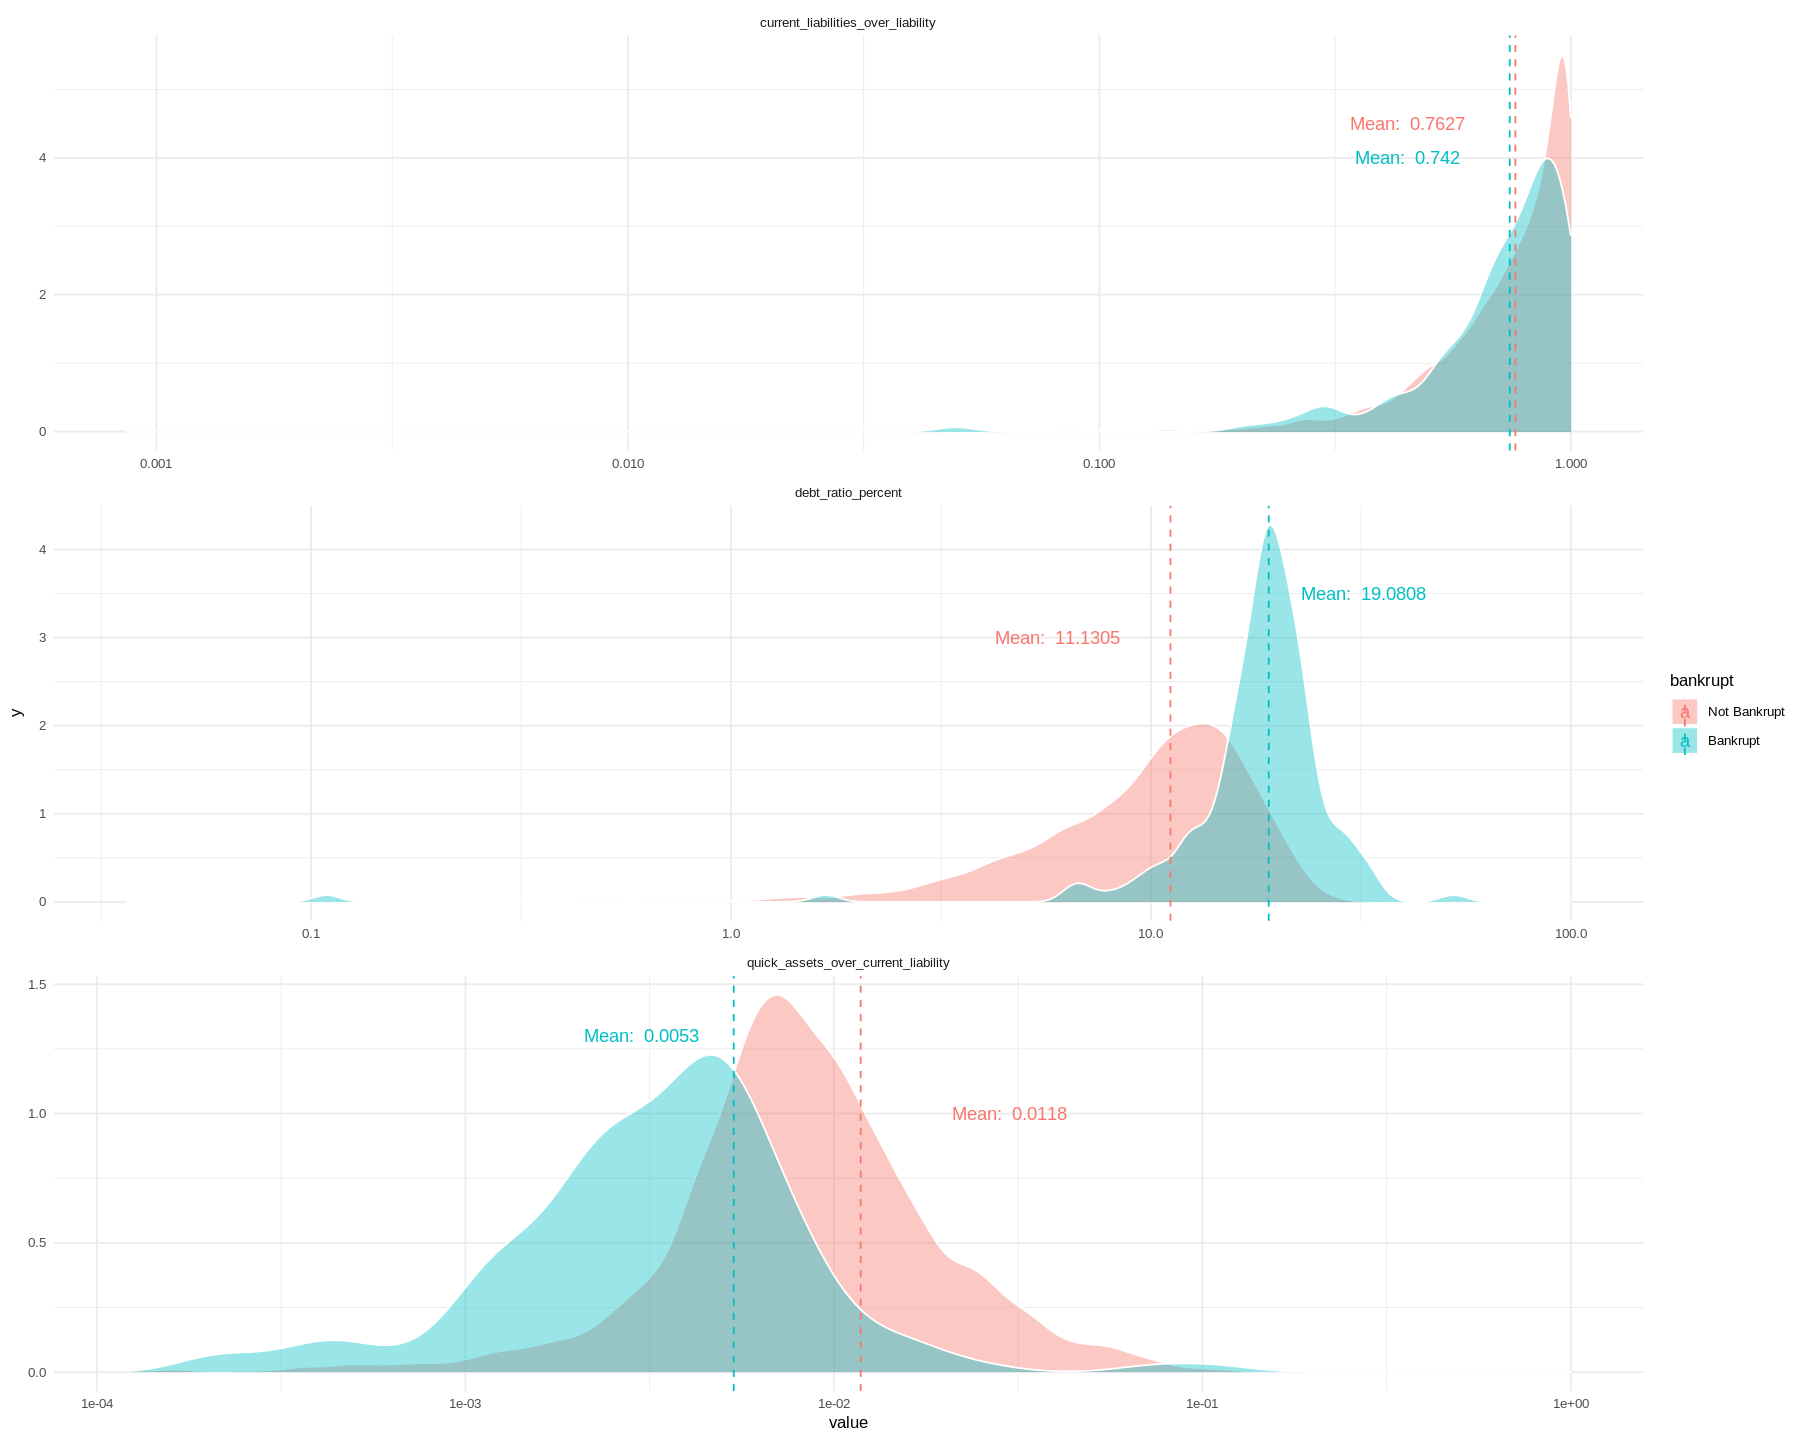

In [21]:
options(repr.plot.height = 12, repr.plot.width = 15)

taiwan_plot_2 <- taiwan_viz |> 
                    ggplot(aes(value, fill = bankrupt)) +
                    geom_density(alpha = 0.4, colour = 'white') +
                    facet_wrap(vars(category), nrow = 3, scales = 'free') +
                    theme_minimal() +
                    scale_x_log10() + #we scale the X axis, as all categories observe a large range in their values
                    geom_vline(data = taiwan_viz_mean, aes (xintercept=value_mean, color=bankrupt), linetype="dashed") +
                    geom_text(data = taiwan_viz_mean, aes(label = paste("Mean: ", round(value_mean,4)), x = x, y = y,  colour = bankrupt)) +
                    theme(text = element_text(size = 10))

taiwan_plot_2

Commentary on performing a visualization of the data set which i srelevant for exploratory data anlysis

In [10]:
#code here

The data analysis

In [11]:
#code here

the visualization(s) of the analysis

In [12]:
#code here

# Discussion

-Summarize what we found
- decide whether this i swhat you expected to find
- discuss what impacts could such findings have
- discuss what future questions could this lead to

# References

MLA or APA